# Models

In [1]:
#Dependencies
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
## import libraries for ARIMA
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow import keras
#show current versions
print("Tensorflow Version:",tf.__version__)
print("Keras Version", keras.__version__)

Tensorflow Version: 2.1.0
Keras Version 2.2.4-tf


## Datasets

In [2]:
path = "./datasets/"
#check location of files
os.getcwd()

'/Users/jacosta3/OneDrive - University of South Florida/Gerdau Projects/pft/submission'

In [3]:
# import data sets
weekly = pd.read_csv(path+'structuralweekly_with_indicators.csv', dtype={'year':object,                                                             'month':object, 'shipment_tons':float, 'production_tons':float,                                                           'fed_construction$B':float, 'state_local_construction$B':float,                     
                           'carbon_bar_ship_usa':float, 'carbon_bar_ship_canada':float, 'structural_ship_usa':float,
                           'structural_ship_canada':float, 'chicago_scrap$ST':float})
monthly = pd.read_csv(path+'structuralmonthly_with_indicators.csv', dtype={'year':object,                                                           'month':object, 'shipment_tons':float, 'production_tons':float,                                                           'fed_construction$B':float, 'state_local_construction$B':float,                     
                           'carbon_bar_ship_usa':float, 'carbon_bar_ship_canada':float, 'structural_ship_usa':float,
                           'structural_ship_canada':float, 'chicago_scrap$ST':float})

## Data Prep

In [4]:
#Changing data types
weekly.calendar_day = weekly.calendar_day.astype('datetime64')
monthly.calendar_day = monthly.calendar_day.astype('datetime64')

### Weekly

In [5]:
# Splitting by years with uneven data points per year
# Source: https://stackoverflow.com/questions/58069691/how-to-create-a-train-test-split-of-time-series-data-by-year
year_list = weekly['year'].unique().tolist()
weekly_splits = {'train': [], 'test': []}

for idx, yr in enumerate(year_list[:-1]):
    train_yr = year_list[:idx+1]
    test_yr = [year_list[idx+1]]
    print('TRAIN: ', train_yr, 'TEST: ',test_yr)

    weekly_splits['train'].append(weekly.loc[weekly.year.isin(train_yr), :])
    weekly_splits['test'].append(weekly.loc[weekly.year.isin(test_yr), :])

print('\n')
# Exception, we only have 3 series (2019 + 2020) should be aggregated(if 2020 is used)
print("Size of the Train-Test Splits:")
print("Train 2016:",weekly_splits['train'][0].shape[0])
print("  Test 2017:",weekly_splits['test'][0].shape[0])
print("Train 2016-17:",weekly_splits['train'][1].shape[0])
print("  Test 2018:",weekly_splits['test'][1].shape[0])
print("Train 2016-18:",weekly_splits['train'][2].shape[0])
print("  Test 2019:",weekly_splits['test'][2].shape[0])
print("Train 2016-19:",weekly_splits['train'][3].shape[0])
print("  Test 2020:",weekly_splits['test'][3].shape[0])

TRAIN:  ['2016'] TEST:  ['2017']
TRAIN:  ['2016', '2017'] TEST:  ['2018']
TRAIN:  ['2016', '2017', '2018'] TEST:  ['2019']
TRAIN:  ['2016', '2017', '2018', '2019'] TEST:  ['2020']


Size of the Train-Test Splits:
Train 2016: 2867
  Test 2017: 3328
Train 2016-17: 6195
  Test 2018: 3260
Train 2016-18: 9455
  Test 2019: 3018
Train 2016-19: 12473
  Test 2020: 46


## Metrics

In [6]:
#notes on why these metrics and source
#Source: https://medium.com/@joydeepubuntu/common-metrics-for-time-series-analysis-f3ca4b29fe42

In [7]:
def score_model(test_y, test_x, model, api=None,):
    '''
    scoring function to be used across model.
    parameters - 
        test_y: dataframe with dependent located in the last row
        test_x: dataframe with independent variables for model ingestion
        model: trained model
        api: 'tf':tensorflow, 'prophet':facebook prophet
    notes:
        for prophet input the 'future' df as test_x, that function will filter out the needed dataframe
    '''
    try:
         test_y = test_y.iloc[:,-1].to_numpy()
    except:
        print('error in converting test')
    if api == 'tf':
        pred_y = scale.inverse_transform(model.predict(test_x))[:,-1]
        test_y = scale.inverse_transform(test_y)
    elif api == 'prophet':
        forecast = prophet.predict(test_x)
        pred_y = forecast[forecast['ds'].dt.year >=2019][['ds','yhat']].rename(columns={'yhat':'y'}).iloc[:,-1].to_numpy()
    else:
        pred_y = model.predict(test_x)
    r2 = r2_score(test_y, pred_y)
    mae = mean_absolute_error(test_y,pred_y)
    rmse = mean_squared_error(test_y, pred_y, squared=False)
    four_pred = pred_y[4:] if api != 'tf' else pred_y
    four_test = test_y[4:] if api != 'tf' else test_y
    print("Test Scores:", )
    print("  Mean Absolute Error(MAE):",mae)
    print("  Root Mean Squared Error(RMSE):",rmse)
    print("  Coefficient of Determination(R2):",r2)
    print("Take 4 Sample Comparison:")
    print("  Predictions:", four_pred[0:4].round().astype(int).transpose())
    print("      Actuals:", four_test[0:4].astype(int).transpose())

Because we know shipments have heavy tails, that are skewed on the left we decided to use MAE as our main scoring, however in comparing models we want to make note of the other metrics(RMSE and R2) that maybe give us an overall understanding of how our models are performing and in what arena a certain model may perform better

# Prophet Univariate

In [8]:
#setting train (2016-2018), test (2019-2020)
train = weekly_splits['train'][2]
test = weekly_splits['test'][2].append(weekly_splits['test'][3], ignore_index=True)

Only one block for analysis: 4" ANG

In [9]:
#filtering block for analysis
train_block = train[train['block']=='4" ANG']
test_block = test[test['block']=='4" ANG']
#size decreases significantly - this could help/hurt
train_block.shape

(157, 18)

In [10]:
#setting up to univariate, prophet ingestion
train_block = train_block.rename(columns={'calendar_day':'ds', 'shipment_tons':'y'})[['ds','y']]
test_block = test_block.rename(columns={'calendar_day':'ds', 'shipment_tons':'y'})[['ds','y']]

#adding a floor for training set
# train_block['cap'] = 2000 #caps seem to have worsen model
# train_block['floor'] = 0 #floors seem to have worsen model

In [11]:
#peek at df
train_block.head(2)

,ds,y
16,2016-01-03,0.0
76,2016-01-10,297.0


### Set-Up & Fitting

In [12]:
#instantiating prophet model with an additive seasonal model, looking at yearly seasonality
prophet = Prophet(seasonality_mode="additive", yearly_seasonality=True,)

prophet.fit(train_block)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Predicting

In [13]:
#creates future calendar with actual dates in training & future dates (determined)
future = prophet.make_future_dataframe(periods=53, freq='W')

#setting up floor and cap
# future['cap'] = 2000 #caps seem to have worsen model
# future['floor'] = 0 #floor seem to have worsen model

In [14]:
#predict future
forecast = prophet.predict(future)

### View Forecast Plot & Components 

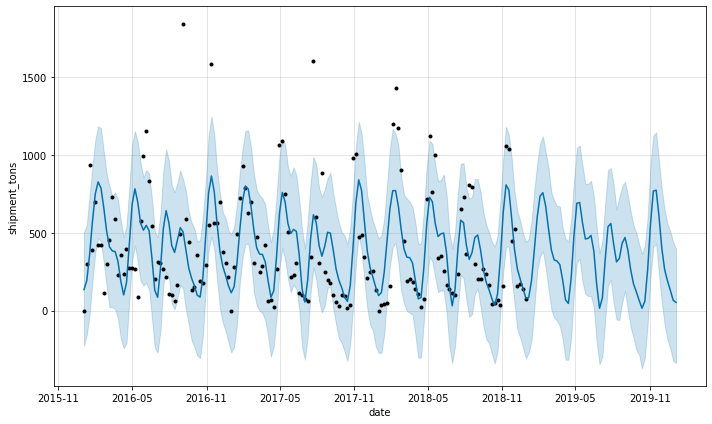

In [15]:
#plot projected shipments
#dark-blue: y_hat(prediction)
#shade-blue: uncertainty interval (range of values at 95%)
#dots: actual points
#dashed lines: cap and floor levels
prophet.plot(forecast, xlabel='date', ylabel='shipment_tons');

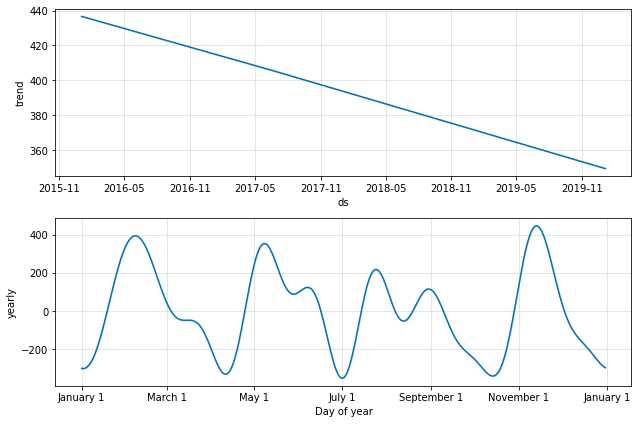

In [16]:
#look at components
#overall trend
#yearly seasonally presented
prophet.plot_components(forecast);

### Scoring

In [18]:
#Metrics provided by prophet make use of cross-validation and applies it to the known years in this case 2017-2018
evaluate = cross_validation(prophet, initial="52 W", horizon="4 W", period="1 W")
%time

INFO:fbprophet:Making 101 forecasts with cutoffs between 2017-01-01 00:00:00 and 2018-12-02 00:00:00
CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10 µs


In [19]:
#see metrics scores for 
performance_metrics(evaluate)

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,7 days,137769.884349,371.173658,278.737816,0.670742,0.693069
1,14 days,174344.483846,417.545787,316.483349,0.748165,0.603960
2,21 days,182927.649323,427.700420,327.289126,0.771558,0.584158
3,28 days,183226.694307,428.049874,327.041020,0.773595,0.594059


### Cross-model evaluation
Predicting on 2019-20 test-set

In [285]:
#Scoring based on 2019-20 test set
score_model(test_block, future, prophet, api='prophet')

Test Scores:
  Mean Absolute Error(MAE): 216.66172387349795
  Root Mean Squared Error(RMSE): 291.39714114195937
  Coefficient of Determination(R2): 0.09333093387467506
Take 4 Sample Comparison:
  Predictions: [735 757 671 524]
      Actuals: [875 736 617 490]


# LSTM Univariate
Can only be used for one product at a time
- Sourced from: https://www.tensorflow.org/tutorials/structured_data/time_series

In [17]:
#function to split univariate data for checking - helps match next upcoming point with the last input
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = [] #list of independent variables
  labels = [] #list of dependent variable

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [18]:
#function to show the appropriate time-step
def create_time_steps(length):
  return list(range(-length, 0))

In [19]:
#function for plotting individual steps
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

### Selecting Block 4" ANG

In [20]:
#Checking Univariate on 4" ANG
uni_data = weekly[weekly['block']=='4" ANG']['shipment_tons']
uni_data.index = weekly[weekly['block']=='4" ANG']['calendar_day']
#converting to dataframe
uni_data = pd.DataFrame(uni_data)
#checking shape
uni_data.shape

(210, 1)

## Train-Test Split

In [21]:
#check last index of 2018 -> use 157
print(uni_data.iloc[155:158,])
#setting index
TRAIN_SPLIT = 157

shipment_tons
calendar_day               
2018-12-23            138.0
2018-12-30             75.0
2019-01-06             53.0


### Scaling Data

In [22]:
#scaling data
scale = StandardScaler()
scale.fit(uni_data[:TRAIN_SPLIT])


StandardScaler(copy=True, with_mean=True, with_std=True)

In [23]:
uni_data_scaled = scale.transform(uni_data)

In [24]:
#Splitting time frames
univariate_past_history = 4
univariate_future_target = 0

#training set
x_train_uni, y_train_uni = univariate_data(uni_data_scaled, 0, TRAIN_SPLIT,
                                            univariate_past_history, 
                                            univariate_future_target)
#test set
x_test_uni, y_test_uni = univariate_data(uni_data_scaled, TRAIN_SPLIT, None,
                                            univariate_past_history, 
                                            univariate_future_target)

In [25]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target shipments to predict')
print (y_train_uni[0])

Single window of past history
[[-1.1178002 ]
 [-0.29474044]
 [ 1.47885635]
 [-0.03147216]]

 Target shipments to predict
[0.81098631]


### Setting up Model

In [26]:
#setting seed for reproductability
tf.random.set_seed(42)

In [27]:
#setting batch size for 3 months (the size of a production cycle)
BATCH_SIZE = 12 # 12 weeks (3 mo)
BUFFER_SIZE = 300 # larger than dataset

#setting up memory and batch sizes
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#no cache, nor shuffle for validation
test_univariate = tf.data.Dataset.from_tensor_slices((x_test_uni, y_test_uni))
test_univariate = test_univariate.batch(BATCH_SIZE).repeat()

In [28]:
#architecture
uni_lstm = keras.models.Sequential([
    keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    keras.layers.Dense(1)
])

#compiler
uni_lstm.compile(optimizer='adam', loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError(),])

In [29]:
for x,y in test_univariate.take(1):
    print(uni_lstm.predict(x).shape)

(12, 1)


### Training Model

In [30]:
#fitting the model
EPOCHS=10 # Number of iterations over the training set (in this case full batch)
EVALUATION_INTERVAL=156 # size of the data for evaluation, in this case the whole data set for this block

uni_lstm.fit(train_univariate, epochs=EPOCHS,
                steps_per_epoch=EVALUATION_INTERVAL,
                validation_data=test_univariate,
                validation_steps=50)

Train for 156 steps, validate for 50 steps
Epoch 1/10
156/156 [==============================] - 4s 27ms/step - loss: 0.6828 - root_mean_squared_error: 0.9590 - val_loss: 0.6196 - val_root_mean_squared_error: 0.8469
Epoch 2/10
156/156 [==============================] - 2s 10ms/step - loss: 0.5876 - root_mean_squared_error: 0.9540 - val_loss: 0.5471 - val_root_mean_squared_error: 0.8250
Epoch 3/10
156/156 [==============================] - 1s 8ms/step - loss: 0.5537 - root_mean_squared_error: 0.9155 - val_loss: 0.4833 - val_root_mean_squared_error: 0.7691
Epoch 4/10
156/156 [==============================] - 1s 8ms/step - loss: 0.5227 - root_mean_squared_error: 0.8565 - val_loss: 0.4415 - val_root_mean_squared_error: 0.7231
Epoch 5/10
156/156 [==============================] - 1s 8ms/step - loss: 0.5014 - root_mean_squared_error: 0.8083 - val_loss: 0.4300 - val_root_mean_squared_error: 0.6812
Epoch 6/10
156/156 [==============================] - 1s 8ms/step - loss: 0.4832 - root_mean_sq

### Scoring Model

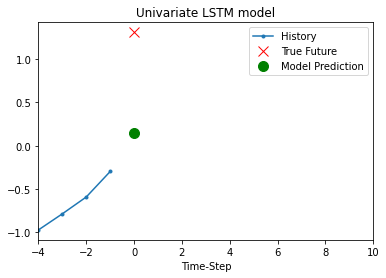

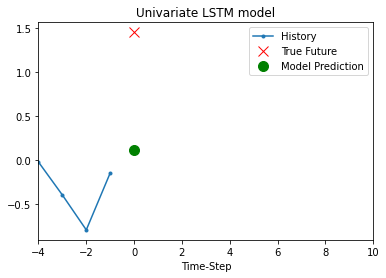

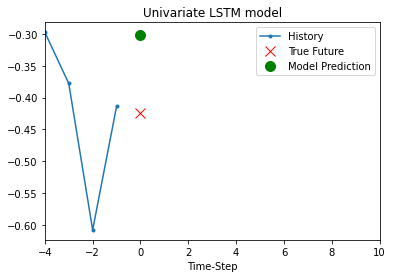

In [31]:
for x, y in test_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    uni_lstm.predict(x)[0]], 0, 'Univariate LSTM model')
  plot.show()

In [32]:
#Results from tensorflow
results = np.round(uni_lstm.evaluate(x_test_uni,y_test_uni,BATCH_SIZE,verbose=0),4)
print("Mean Absolute Error {}, Root Mean Squared Error {}".format(results[0],results[1]))

Mean Absolute Error 0.4943, Root Mean Squared Error 0.635


### Cross-model evaluation
Predicting on 2019-20 test-set

In [33]:
#reshaping for scoring
y_test_univariate = y_test_uni.reshape(-1)

In [34]:
#note, these models skip 4 weeks worth of data, for the first analysis
score_model(y_test_univariate,x_test_uni,uni_lstm,api='tf')

error in converting test
Test Scores:
  Mean Absolute Error(MAE): 178.38460276078206
  Root Mean Squared Error(RMSE): 229.1543650580632
  Coefficient of Determination(R2): 0.44550374282428884
Take 4 Sample Comparison:
  Predictions: [456 874 579 434]
      Actuals: [875 736 617 490]


# LSTM Multivariate Models

## Uniclass - Individual Block

In [35]:
#import data
data = weekly.drop(columns=['calendar_day','year'])
data.index = weekly['calendar_day']
data.month = data.month.astype(float)

In [36]:
## select columns with highest correlation
columns = ['month','state_local_construction$B', 'carbon_bar_ship_canada','block', 
           'inventory_tons', 'production_tons', 'sale_order_tons', 'shipment_tons']

data = data[columns]
data.shape

(12519, 8)

### Selecting Block 4" ANG

In [37]:
#select specific block
data = data[data['block']=='4" ANG']
#check data size
data.shape

(210, 8)

### Transforming Variables

In [38]:
scale_x = StandardScaler()
scale = StandardScaler()
min_max = MinMaxScaler()
one_hot = OneHotEncoder(sparse=False)

#fitting
month = min_max.fit_transform(data['month'].to_numpy().reshape(-1, 1))
block = one_hot.fit_transform(data['block'].to_numpy().reshape(-1,1))
#note only fitting numerical on training
scale_x.fit(data[0:TRAIN_SPLIT][data.columns.drop(['month','block','shipment_tons'])])
scale.fit(data[0:TRAIN_SPLIT]['shipment_tons'].to_numpy().reshape(-1,1))
values = scale_x.transform(data[data.columns.drop(['month','block','shipment_tons'])])
y = scale.transform(data['shipment_tons'].to_numpy().reshape(-1,1))

In [39]:
#Prepared dataframe
data_prepared = np.concatenate([month,block,values,y], axis=1)

In [40]:
#function to split multivariate data
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [41]:
#data split for all blocks by time frame
TRAIN_SPLIT = 157 #size of dataframe up to 2018
past_history = 4 # 4 weeks of data
future_target = 0 # how far out do we want to forecast 0-> next week
STEP = 1 # more than one if we don't want use all the data points in the sample

x_train_single, y_train_single = multivariate_data(data_prepared, data_prepared[:, -1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(data_prepared, data_prepared[:, -1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [42]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (4, 8)


In [43]:
#setting batch size for 3 months (the size of a production cycle)
BATCH_SIZE = 12 #2-3 times the size of the past_history
BUFFER_SIZE = 210 #size of data to shuffle, should be set slightly larger or equal to dataset size

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))#Creates tensor slices of data for keras model ingestion
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()#stores slices of data in cache, shuffles and stores to size batches 

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [44]:
#model architecture (TURN-OFF FIRST INSTANCE)
#del single_step_model
single_step_model = keras.models.Sequential()
single_step_model.add(keras.layers.LSTM(160, input_shape=x_train_single.shape[-2:])) # number of variables * 20
single_step_model.add(keras.layers.Dense(1)) #only one output layer

single_step_model.compile(optimizer=keras.optimizers.RMSprop(), loss='mae',metrics=[tf.keras.metrics.RootMeanSquaredError()])

### Training Model

In [45]:
#parameters
EPOCHS=10
EVALUATION_INTERVAL=15

#clearing weights and any other remnants from models-past
keras.backend.clear_session()
#fitting the model
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=5)

Train for 15 steps, validate for 5 steps
Epoch 1/10
15/15 [==============================] - 4s 242ms/step - loss: 0.5763 - root_mean_squared_error: 0.8582 - val_loss: 0.3866 - val_root_mean_squared_error: 0.6434
Epoch 2/10
15/15 [==============================] - 0s 14ms/step - loss: 0.4396 - root_mean_squared_error: 0.7198 - val_loss: 0.4662 - val_root_mean_squared_error: 0.6829
Epoch 3/10
15/15 [==============================] - 0s 13ms/step - loss: 0.4241 - root_mean_squared_error: 0.6684 - val_loss: 0.3865 - val_root_mean_squared_error: 0.6000
Epoch 4/10
15/15 [==============================] - 0s 14ms/step - loss: 0.3780 - root_mean_squared_error: 0.6179 - val_loss: 0.3956 - val_root_mean_squared_error: 0.5805
Epoch 5/10
15/15 [==============================] - 0s 14ms/step - loss: 0.3576 - root_mean_squared_error: 0.5538 - val_loss: 0.3395 - val_root_mean_squared_error: 0.5615
Epoch 6/10
15/15 [==============================] - 0s 14ms/step - loss: 0.3287 - root_mean_squared_err

### Scoring Model

In [46]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

### Setting Up Model

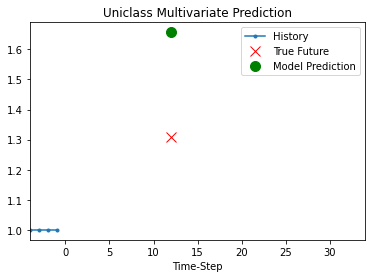

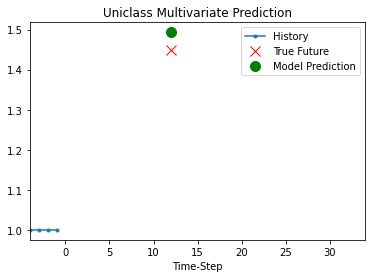

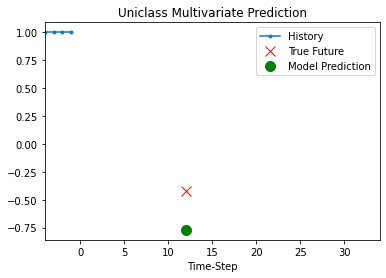

In [48]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Uniclass Multivariate Prediction')
  plot.show()

In [49]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(12, 1)


In [51]:
#Results from tensorflow
results = np.round(single_step_model.evaluate(x_val_single,y_val_single,BATCH_SIZE,verbose=0),4)
print("Mean Absolute Error {}, Root Mean Squared Error {}".format(results[0],results[1]))

Mean Absolute Error 0.4254, Root Mean Squared Error 0.5953


### Cross-model evaluation
Predicting on 2019-20 test-set

In [52]:
score_model(y_val_single, x_val_single, single_step_model, api='tf')

error in converting test
Test Scores:
  Mean Absolute Error(MAE): 153.51630892072404
  Root Mean Squared Error(RMSE): 214.81452430562263
  Coefficient of Determination(R2): 0.5127300440635135
Take 4 Sample Comparison:
  Predictions: [1001  960  789  574]
      Actuals: [875 736 617 490]


## Multiclass - All blocks (Weekly)

In [93]:
#import data
data = weekly.drop(columns=['calendar_day','year'])
data.index = weekly['calendar_day']
data.month = data.month.astype(float)

In [94]:
## select columns with highest correlation
columns = ['month','state_local_construction$B', 'carbon_bar_ship_canada','block', 
           'inventory_tons', 'production_tons', 'sale_order_tons', 'shipment_tons']

data = data[columns]
data.shape

(12519, 8)

### Checking Index for Split

In [95]:
#checking spot for train_split
TRAIN_SPLIT2 = 9455 #size of dataframe up to 2018
weekly.iloc[9454:9457,:]

,calendar_day,year,month,global_steel_utilization,fed_construction$B,state_local_construction$B,carbon_bar_ship_usa,carbon_bar_ship_canada,structural_ship_usa,structural_ship_canada,ism_manufacturing,ism_non_manufacturing,chicago_scrap$ST,block,inventory_tons,production_tons,sale_order_tons,shipment_tons
9454,2018-12-30,2018,12,0.7620,1783.0,19153.0,177300.0,21900.0,174200.0,25500.0,54.3,58.0,405.0,"6"" FLT",6793.732139,-2.0,290.1270,3.0
9455,2019-01-06,2019,1,0.7768,1601.0,18166.0,222800.0,34800.0,201600.0,34200.0,56.6,56.7,375.0,"1"" FLT",0.004000,0.0,15.0590,3.0
9456,2019-01-06,2019,1,0.7768,1601.0,18166.0,222800.0,34800.0,201600.0,34200.0,56.6,56.7,375.0,"5"" CHN",4213.412014,-9.0,110.9505,39.0


### Transforming Variables

In [96]:
scale_x = StandardScaler()
scale = StandardScaler()
min_max = MinMaxScaler()
one_hot = OneHotEncoder(sparse=False)

#fitting
month = min_max.fit_transform(data['month'].to_numpy().reshape(-1, 1))
block = one_hot.fit_transform(data['block'].to_numpy().reshape(-1,1))
#note only fitting numerical on training
scale_x.fit(data[0:TRAIN_SPLIT2][data.columns.drop(['month','block','shipment_tons'])])
scale.fit(data[0:TRAIN_SPLIT2]['shipment_tons'].to_numpy().reshape(-1,1))
values = scale_x.transform(data[data.columns.drop(['month','block','shipment_tons'])])
y = scale.transform(data['shipment_tons'].to_numpy().reshape(-1,1))

In [97]:
#Prepared dataframe
data_prepared = np.concatenate([month,block,values,y], axis=1)

In [98]:
data_prepared.shape

(12519, 82)

### Train-Test Split

In [99]:
#function to split multivariate data
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [100]:
#data split for all blocks by time frame
past_history = 260 # 4 weeks of data (~65 blocks/week X 4 weeks )
future_target = 260 # how far out do we want to forecast 0-> next week
STEP = 1 # more than one if we don't want use all the data points in the sample

x_train_multi, y_train_multi = multivariate_data(data_prepared, data_prepared[:, -1], 0,
                                                   TRAIN_SPLIT2, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_multi, y_val_multi = multivariate_data(data_prepared, data_prepared[:, -1],
                                               TRAIN_SPLIT2, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [101]:
print ('Single window of train past history : {}'.format(x_train_multi[0].shape))
print ('Single window of prediction past history : {}'.format(x_val_multi[0].shape))

Single window of train past history : (260, 82)
Single window of prediction past history : (260, 82)


### Setting Up Model

In [102]:
#setting batch size for 2-3 months (the size of a production cycle)
BATCH_SIZE = 780 #2-3 times the size of the past_history
BUFFER_SIZE = 10000 #size of data to shuffle, should be set slightly larger or equal to dataset size

##NEED TO LOOK UP AND EXPLAIN THIS
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi)) #Creates tensor slices of data for keras model ingestion
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat() #stores slices of data in cache, shuffles and stores to size batches 

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat() 

In [110]:
#deleting saved model for re-runs (TURN-OFF FIRST INSTANCE)
del single_step_multiclass
#creating model architecture
single_step_multiclass = keras.models.Sequential()
single_step_multiclass.add(keras.layers.LSTM(328, input_shape=x_train_multi.shape[-2:])) # number of variables * 4
single_step_multiclass.add(keras.layers.Dense(1)) #only one output layer

single_step_multiclass.compile(optimizer=keras.optimizers.RMSprop(), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])

### Training Model

In [111]:
#parameters
EPOCHS=3 #number of times to run train 
EVALUATION_INTERVAL=12 #how many steps are taken during epoch - 3 years worth of data(9600 points) divided by steps of 780 points (8/weeks)

#clearing weights and any other remnants from models-past
keras.backend.clear_session()
#fitting the model
single_step_history = single_step_multiclass.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=4)

Train for 12 steps, validate for 4 steps
Epoch 1/3
12/12 [==============================] - 485s 40s/step - loss: 0.4826 - root_mean_squared_error: 1.0573 - val_loss: 0.4349 - val_root_mean_squared_error: 0.9867
Epoch 2/3
12/12 [==============================] - 502s 42s/step - loss: 0.4305 - root_mean_squared_error: 1.0556 - val_loss: 0.4331 - val_root_mean_squared_error: 0.9859
Epoch 3/3
12/12 [==============================] - 373s 31s/step - loss: 0.4221 - root_mean_squared_error: 1.0597 - val_loss: 0.4344 - val_root_mean_squared_error: 0.9337


### Scoring Model

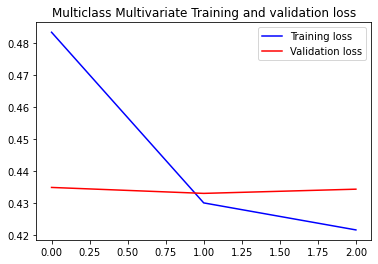

In [112]:
plot_train_history(single_step_history,
                   'Multiclass Multivariate Training and validation loss')

In [113]:
# def plot_train_history(history, title):
#   loss = history.history['loss']
#   val_loss = history.history['val_loss']

#   epochs = range(len(loss))

#   plt.figure()

#   plt.plot(epochs, loss, 'b', label='Training loss')
#   plt.plot(epochs, val_loss, 'r', label='Validation loss')
#   plt.title(title)
#   plt.legend()

#   plt.show()

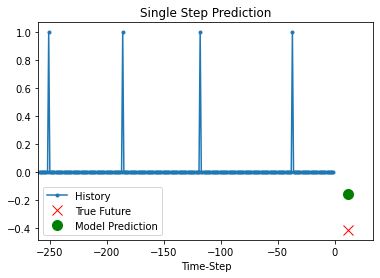

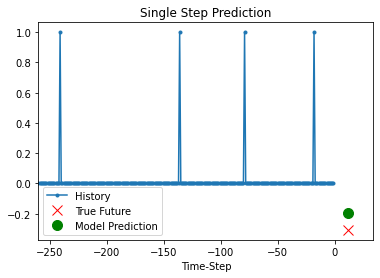

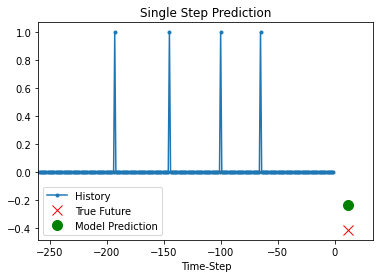

In [114]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_multiclass.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [115]:
#Results from tensorflow
results = np.round(single_step_multiclass.evaluate(x_val_multi,y_val_multi,BATCH_SIZE,verbose=0),4)
print("Mean Absolute Error {}, Root Mean Squared Error {}".format(results[0],results[1]))

Mean Absolute Error 0.4471, Root Mean Squared Error 0.9337


### Cross-model evaluation
Predicting on 2019-20 test-set

In [116]:
type(y_val_multi), type(x_val_multi)

(numpy.ndarray, numpy.ndarray)

In [117]:
y_val_multi.shape, x_val_multi.shape

((2544,), (2544, 260, 82))

In [119]:
score_model(y_val_multi,x_val_multi,single_step_multiclass,api='tf')

error in converting test
Test Scores:
  Mean Absolute Error(MAE): 54.15628696472015
  Root Mean Squared Error(RMSE): 113.09362900212503
  Coefficient of Determination(R2): -0.06401682731568603
Take 4 Sample Comparison:
  Predictions: [31 28 26 27]
      Actuals: [  0   0 357   4]


## Monthly Multiclass

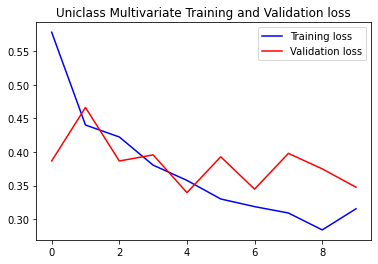

In [47]:
plot_train_history(single_step_history,
                   'Uniclass Multivariate Training and Validation loss')